In [1]:
import pandas as pd
import numpy as np
import nannyml as nml
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to plot my confusion matrix
# code taken at https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
df_training = pd.read_csv('training_df.csv')
df_training['cut'] = df_training['cut'].replace({1:'fair', 2:'good', 3:'very_good', 4:'premium', 5:'ideal'})

In [4]:
df_prod = pd.read_csv('data_production.csv')
targets = pd.read_csv('targets_analysis.csv').set_index('identifier')

# lets put the real targets again
df_prod['y_true'].fillna(targets.y_true.to_dict(), inplace=True)

# Has the data drifted ?

We can see from the univariate calculator that all my features seem to drift at the same time around november 2073.



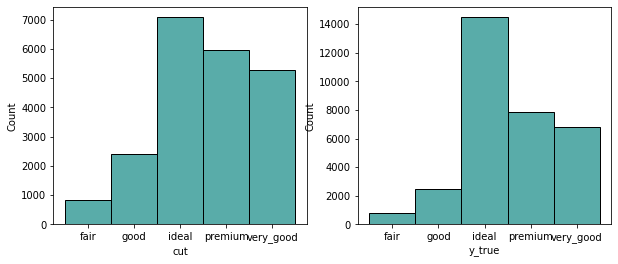

In [5]:
# lets look at the distribution of the target in train and prod
palette=sns.color_palette('viridis', df_training.cut.unique().shape[0])

fig,axes = plt.subplots(nrows=1,ncols=2, figsize=(10,2*2))

sns.histplot(x=df_training.cut.sort_values(), color=palette[2], ax=axes[0])
sns.histplot(x=df_prod.y_true.sort_values(), color=palette[2], ax=axes[1])

plt.show();

# Dont seem far 

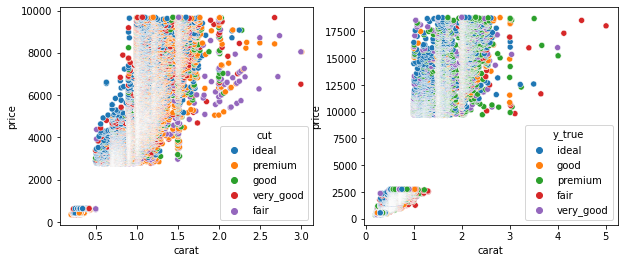

In [6]:
palette=sns.color_palette('viridis', df_training.cut.unique().shape[0])

fig,axes = plt.subplots(nrows=1,ncols=2, figsize=(10,2*2))

sns.scatterplot(y='price', x='carat', color=palette[2], hue='cut' ,ax=axes[0], data=df_training)
sns.scatterplot(y='price', x='carat', color=palette[2],  hue='y_true', ax=axes[1], data=df_prod)

plt.show();

So here we can see indeed that there is a difference in the dataset between the training and the production !!
on the left we have the distribution that goes until 10_000 and on the right is goes from 10_000 to 17_500$$. 

This is a huge change, The dataset had a huge shift of value in price between the training and production.

--> as the price is influence by the clarity (purety), color and size of the diamonds it fair to guess that they have a completely different distribution as well and thats what made our data drift.

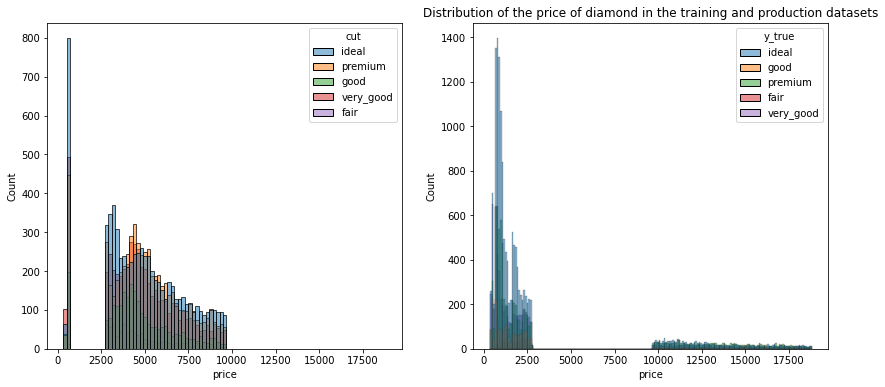

In [7]:
palette=sns.color_palette('viridis', df_training.cut.unique().shape[0])

fig,axes = plt.subplots(nrows=1,ncols=2, figsize=(14,3*2), sharex=True)

sns.histplot(x='price', color=palette[2], hue='cut' ,ax=axes[0], data=df_training)
sns.histplot(x='price', color=palette[2],  hue='y_true', ax=axes[1], data=df_prod)

plt.title('Distribution of the price of diamond in the training and production datasets')
fig.savefig('Plots/distributions_target_trte.png')
plt.show();

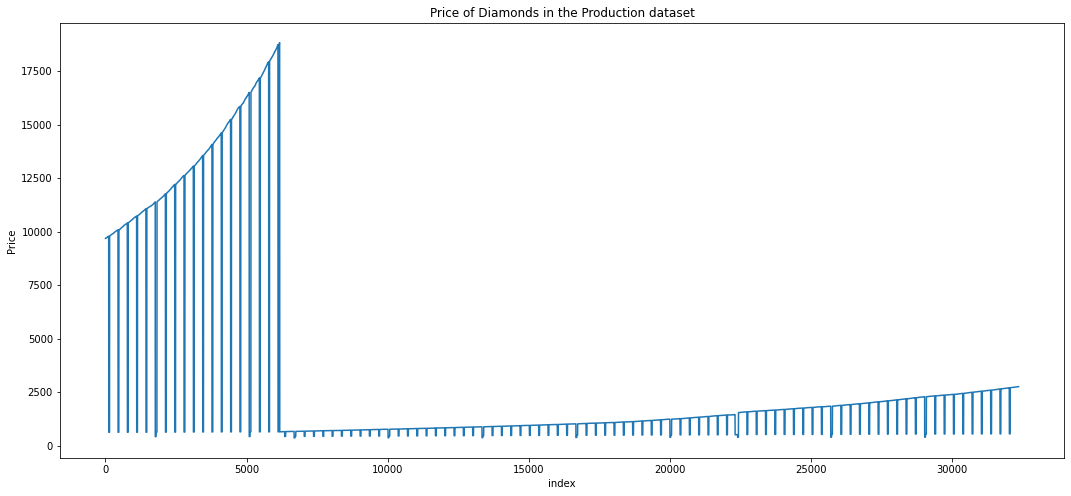

In [8]:
f = plt.figure(figsize=(18,8))
#sns.lineplot(y="price", data=df_prod)
plt.plot(df_prod.price)
plt.title('Price of Diamonds in the Production dataset')
plt.savefig('Plots/droptheprice.png')
plt.xlabel('index')
plt.ylabel('Price')
plt.show();

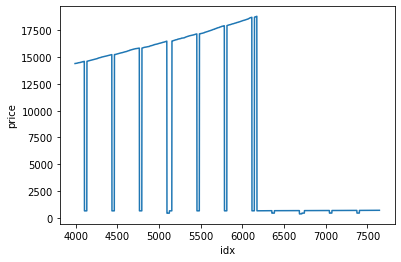

In [9]:
df_prod.loc[(df_prod.timestamp >= '2030-01-01') & (df_prod.timestamp <= '2040-01-01'), 'price'].plot();
plt.xlabel('idx')
plt.ylabel('price')
plt.show()

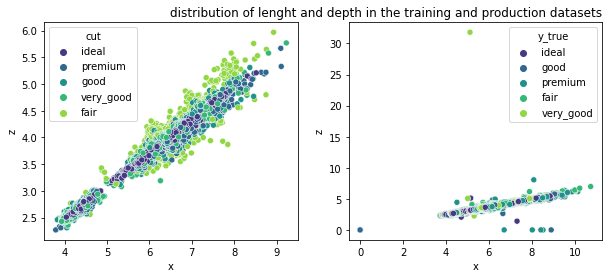

In [10]:
palette=sns.color_palette('viridis', df_training.cut.unique().shape[0])

fig,axes = plt.subplots(nrows=1,ncols=2, figsize=(10,2*2))

sns.scatterplot(y='z', x='x', color=palette[2], hue='cut', palette=palette, ax=axes[0], data=df_training)
sns.scatterplot(y='z', x='x', color=palette[2],  hue='y_true', palette=palette, ax=axes[1], data=df_prod)

plt.title('distribution of lenght and depth in the training and production datasets',loc='right')
plt.savefig('Plots/distr_df.png')
plt.show();

In [11]:
# subset df when our model is losing pred
subset_df_1 = df_prod.loc[(df_prod.timestamp >= '2065-01-01') & (df_prod.timestamp <= '2085-01-01')]
# before that 
subset_df = df_prod.loc[(df_prod.timestamp >= '2020-01-01') & (df_prod.timestamp <= '2040-01-01')]

# lets watch the distrib of certain feat in the diff datasets

print(f'median prices during training: {df_training.price.median():.2f} $') # median more robust than mean()!
print(f'median prices before lost of perf: {subset_df.price.median():.2f} $')
print(f'median prices during of perf: {subset_df_1.price.median():.2f} $')    

median prices during training: 4628.00 $
median prices before lost of perf: 11722.50 $
median prices during of perf: 1233.00 $


median length during training: 6.42 $
median length before lost of perf: 7.37 $
median length during of perf: 5.03 $


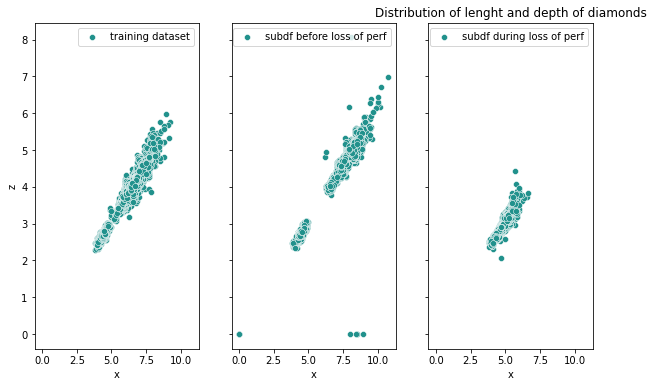

In [12]:
print(f'median length during training: {df_training.x.median():.2f} $') # median more robust than mean()!
print(f'median length before lost of perf: {subset_df.x.median():.2f} $')
print(f'median length during of perf: {subset_df_1.x.median():.2f} $')

palette=sns.color_palette('viridis', df_training.cut.unique().shape[0])

fig,axes = plt.subplots(nrows=1,ncols=3, figsize=(10,3*2), sharey=True, sharex=True)

sns.scatterplot(y='z', x='x', color=palette[2],  ax=axes[0], data=df_training, label='training dataset')
sns.scatterplot(y='z', x='x', color=palette[2], ax=axes[1], data=subset_df, label='subdf before loss of perf')
sns.scatterplot(y='z', x='x', color=palette[2],  ax=axes[2], data=subset_df_1, label='subdf during loss of perf')

plt.title('Distribution of lenght and depth of diamonds')

fig.savefig('Plots/distribution_lenght_depth')
plt.show();
# x=length, z=depth of diamond

## conclusion on data drifting

As in the assessment statement, I went directly to separate my dataset and it turns out that the price of diamonds was increasing throughout the dataset to fall at the end! Now, I thought about just shuffling the dataset and getting my scripts to work again, but then I thought this would be a good example of nannyml catching a data drift as the price of our feature is changing completely to $ 18_000 and then back to moderate prices.

The interesting part with our data drift is that nannyml doesn't seem to detect the rise or fall but after, between 20_000 and the end (idx).

The price going up doesn't seem to change the performance of the model or result in data drift nor the abrupt change between prices (18_000 --> >1000 $) which is not detected by the univariate calculator. But the constant low prices under 1000 dollars raise a red flag for the features and leads to a loss in prediction.

# Is the model still performing well? how is the data drift impacting the performance of the model?

The model seems to perform poorly on the roc_auc metric between april and may 2068 and regain a good score between septembre and novembre 2084.

--> As stated before its due to the huge difference in the price change.

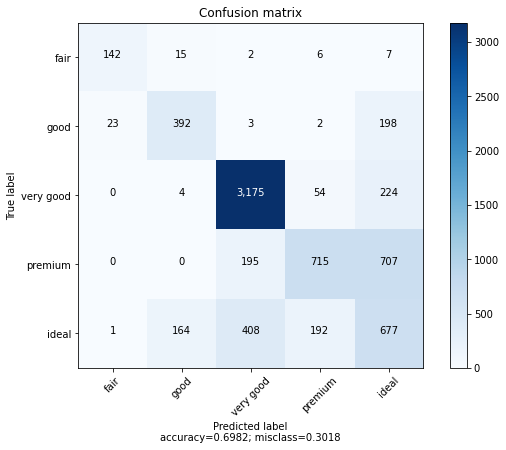

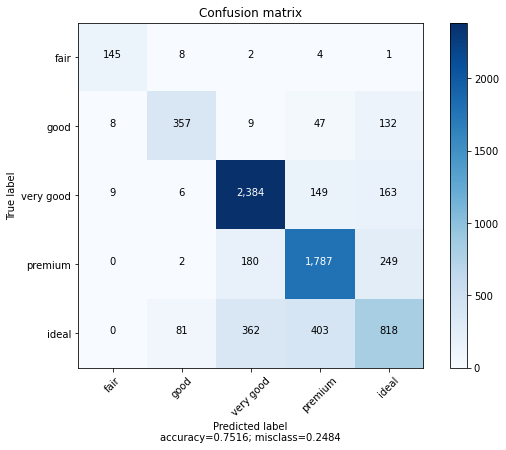

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# y_pred/true of a subset during the roc_auc score problem detected by nannyml
y_pred = subset_df_1.y_pred
y_true = subset_df_1.y_true

report = classification_report(y_true=y_true, y_pred=y_pred)

# Confusion matrix
matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

plot_confusion_matrix(matrix, ['fair', 'good', 'very good', 'premium', 'ideal'])

# -------------------------------------------
# y_pred/true of the subset before to compare
y_pred = subset_df.y_pred
y_true = subset_df.y_true

report = classification_report(y_true=y_true, y_pred=y_pred)

# Confusion matrix
matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

plot_confusion_matrix(matrix, ['fair', 'good', 'very good', 'premium', 'ideal'])

## outcomes of the confusion matrix 
The y axe show the true label and the x axe the predicted label. We can see that our model has a lot of trouble predicting the ideal category (makes a lot of mistakes on that one).

As they are more 'ideal' cutted diamonds in the dataset when we are losing prediction power we can hypothesize that we are losing accuracy because of that.
The loss of perf is not during the rise or fall of the model but after during the constant of low prices, dur to a change of the target distribution (more ideal diamonds).

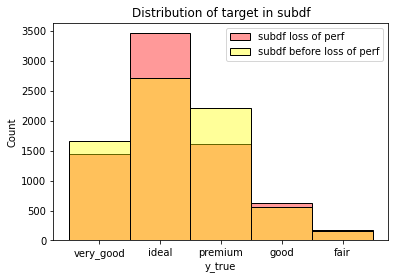

In [14]:
# distribution of target in the sub datasets
sns.histplot(subset_df_1.y_true, color='red', alpha=0.4, label='subdf loss of perf')
sns.histplot(subset_df.y_true, color='yellow', alpha=0.4, label='subdf before loss of perf')

plt.legend()
plt.title('Distribution of target in subdf')
plt.savefig('Plots/distribution_target.png')
plt.show();

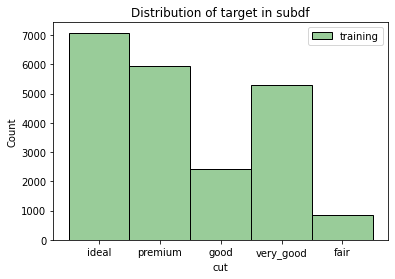

In [15]:
# distribution of target in the sub datasets

sns.histplot(df_training.cut, color='green', alpha=0.4, label='training')
plt.legend()
plt.title('Distribution of target in subdf')
plt.savefig('Plots/distribution_target_training.png')
plt.show();

The loss of score in our model was coming from the unequal distribution of the target at that given time.
The model did not lose performance during the rise of prices because the distribution of params seems to be closer to its training distribution but lost prediction power when the price diamond went super low with a different distribution of params.

# Was there any training-serving skew?

There was, due to unequal distribution in the data during production.

The model lost 5%, which in a real environment could lead to dramatic outcomes. But in this case I am even surprise that it lost just 5% because there is such a discrepancy between training and serving data that I could have imagine losing much more accuracy.

The training data and serving data had different distribution of features and target resulting in this lost of perf and data drift.

# What might be the cause of the issues ?

To summarize our issues here:

Data drift:
- the price of the diamonds was highly skewed in the original dataset and its distribution was unequal to the training and production datasets, it increased in the training data and continued to increase in the production dataset then suddenly went down for the rest of the production data;
- As the price of the diamonds impacts all the other features (and vice versa) we had a change of distribution in our production dataset;
- This change of distribution in our features was detected by nannyml.

model performance:
- The distribution of the data going up was well compensated by our model because the features had more or less the same distribution but when it went completely down, the distribution of the feats changed, which may have impacted the target;
- The change in model prediction power (it lost about 5% on the production but almost 9% during the detected period) was also detected. After investigation, it was due to the distribution of the target was unequal: with more of the 'ideal' cut which our model had a hard time predicting.

# Is there any concept drift?

The concept drift is a change in the dependant variable. So changes in our target variable. 

Even if there was slight change in the distribution that is not equal as a concept drift. <br>
There wasnt any in this dataset, but we could easily imagine some concept drift inserting itself, for example if the cut of the diamond gets another grade (going from 'fair, good, very good, premium and ideal' and adding 'poor' or 'perfect') and our model doesnt know about it. This would necessite a refitting of the model with actual data that includes the new grade of cut. 